In [8]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.utils import resample
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import xgboost as xgb

# First
path1_10_present = 'foia-504-fy2010-present-asof-240930.csv'
path1_91_09 = 'foia-504-fy1991-fy2009-asof-240930.csv'

# Second
path2_10_present = '/content/drive/My Drive/MS&E246/10_present.csv'
path2_91_09 = '/content/drive/My Drive/MS&E246/91_09.csv'

try:

    df_10_present = pd.read_csv(path1_10_present)
    df_91_09 = pd.read_csv(path1_91_09)
    print("Successfully read from folder ID path")
except:
    try:

        df_10_present = pd.read_csv(path2_10_present)
        df_91_09 = pd.read_csv(path2_91_09)
        print("Successfully read from folder name path")
    except Exception as e:
        print(f"Error: {e}")

Successfully read from folder ID path


In [9]:
import pandas as pd

# File paths
path1_10_present = 'foia-504-fy2010-present-asof-240930.csv'
path1_91_09 = 'foia-504-fy1991-fy2009-asof-240930.csv'

path2_10_present = '/content/drive/My Drive/MS&E246/10_present.csv'
path2_91_09 = '/content/drive/My Drive/MS&E246/91_09.csv'


try:
    df_10_present = pd.read_csv(path1_10_present)
    df_91_09 = pd.read_csv(path1_91_09)
    print("Successfully read from folder ID path")
except:
    try:
        df_10_present = pd.read_csv(path2_10_present)
        df_91_09 = pd.read_csv(path2_91_09)
        print("Successfully read from folder name path")
    except Exception as e:
        print(f"Error: {e}")

common_columns = list(set(df_10_present.columns).intersection(set(df_91_09.columns)))
df_10_present = df_10_present[common_columns]
df_91_09 = df_91_09[common_columns]

# Concatenate the datasets (91_09 above, 10_present below)
df_combined = pd.concat([df_91_09, df_10_present], ignore_index=True)

# Output the shape and preview of the combined dataframe
print(f"Combined dataset shape: {df_combined.shape}")
print(df_combined.head())

# Save the combined dataset to a new file if needed
output_path = 'combined_dataset.csv'
df_combined.to_csv(output_path, index=False)
print(f"Combined dataset saved to: {output_path}")


Successfully read from folder ID path
Combined dataset shape: (218095, 38)
  FirstDisbursementDate FranchiseName           SBADistrictOffice  \
0            11/13/1991           NaN  SAN DIEGO DISTRICT OFFICE    
1            10/16/1991           NaN       UTAH DISTRICT OFFICE    
2            11/13/1991           NaN    WYOMING DISTRICT OFFICE    
3             7/15/1992           NaN    INDIANA DISTRICT OFFICE    
4             2/13/1991           NaN    INDIANA DISTRICT OFFICE    

   ChargeOffDate  GrossApproval        CDC_City                  CDC_Street  \
0            NaN       175000.0       San Diego  2448 Historic Decatur Road   
1            NaN       231000.0  Salt Lake City        2595 East 3300 South   
2            NaN       370000.0  Salt Lake City        2595 East 3300 South   
3            NaN       561000.0    Indianapolis       4181 East 96th Street   
4            NaN       310000.0    Indianapolis       4181 East 96th Street   

  BorrState                        

In [10]:
#Concat both 504 datsets
df_combined = pd.concat([df_91_09, df_10_present], ignore_index=True)
print(f"Combined dataset shape: {df_combined.shape}")
print(df_combined.head())

# Save the combined dataset to a new file if needed
output_path = 'combined_dataset.csv'
df_combined.to_csv(output_path, index=False)
print(f"Combined dataset saved to: {output_path}")

Combined dataset shape: (218095, 38)
  FirstDisbursementDate FranchiseName           SBADistrictOffice  \
0            11/13/1991           NaN  SAN DIEGO DISTRICT OFFICE    
1            10/16/1991           NaN       UTAH DISTRICT OFFICE    
2            11/13/1991           NaN    WYOMING DISTRICT OFFICE    
3             7/15/1992           NaN    INDIANA DISTRICT OFFICE    
4             2/13/1991           NaN    INDIANA DISTRICT OFFICE    

   ChargeOffDate  GrossApproval        CDC_City                  CDC_Street  \
0            NaN       175000.0       San Diego  2448 Historic Decatur Road   
1            NaN       231000.0  Salt Lake City        2595 East 3300 South   
2            NaN       370000.0  Salt Lake City        2595 East 3300 South   
3            NaN       561000.0    Indianapolis       4181 East 96th Street   
4            NaN       310000.0    Indianapolis       4181 East 96th Street   

  BorrState                        CDC_Name  ApprovalFiscalYear  ...  \
0

In [32]:
df = pd.read_csv('combined_dataset.csv', low_memory=False)

In [33]:
df["AsOfDate"] = pd.to_datetime(df["AsOfDate"], errors='coerce')
df["ApprovalDate"] = pd.to_datetime(df["ApprovalDate"], errors='coerce')

In [34]:
from datetime import datetime
## 3.1.1 Loans that are in EXEMPT state

df_before_and_exempt = df[df["LoanStatus"] == "EXEMPT"]
# Not default
df_before_and_exempt["Default"] = False
# Survival time is (CUTOFF - approval date)
df_before_and_exempt["SurvivalDays"] = (df_before_and_exempt["AsOfDate"] - df_before_and_exempt["ApprovalDate"]).dt.days
# Loss at default is 0
df_before_and_exempt["LossAtDefault"] = 0

In [35]:
# 3.1.2(a) PIF treat as paid at maturity
df_before_and_pif_1 = df[df["LoanStatus"] == "PIF"]
# Not default
df_before_and_pif_1["Default"] = False
# Survival time is the term
df_before_and_pif_1["SurvivalDays"] = df_before_and_pif_1["TermInMonths"] * 30
# Loss at default is 0
df_before_and_pif_1["LossAtDefault"] = 0

In [36]:
df_before_and_chgoff = df[df["LoanStatus"] == "CHGOFF"]
df_before_and_chgoff["ChargeOffDate"] = df_before_and_chgoff["ChargeOffDate"].apply(pd.to_timedelta,unit = 'D') + datetime.strptime("1900-01-01", '%Y-%m-%d')
# Default is true
df_before_and_chgoff["Default"] = True
# Survival time is (charge off date - approval date)
df_before_and_chgoff["SurvivalDays"] = (df_before_and_chgoff["ChargeOffDate"] - df_before_and_chgoff["ApprovalDate"]).dt.days
# Loss at default is gross charge off amount
df_before_and_chgoff["LossAtDefault"] = df_before_and_chgoff["GrossChargeOffAmount"]

In [37]:
df = pd.concat([df_before_and_exempt, df_before_and_pif_1, df_before_and_chgoff])

In [38]:
#Step one: hot encode TermsInMonths

convert_columns = {'NaicsCode': str, 'ApprovalFiscalYear': int}  # Add other columns as needed
for col, dtype in convert_columns.items():
    df[col] = df[col].apply(pd.to_numeric, errors='coerce').astype(dtype)  # Convert to numeric and handle errors

# one-hot encoding
term_dummies = pd.get_dummies(df['TermInMonths'], prefix='TermInMonths')
#df = pd.concat([df.drop('TermInMonths', axis=1), term_dummies], axis=1)
df = pd.concat([df, term_dummies], axis=1)

# Save
output_path = 'combined_dataset_encoded.csv'
df.to_csv(output_path, index=False)
print(f"Dataset saved to: {output_path}")

# Check the DataFrame
print(df.dtypes)  # This will show the data types of all columns
print("Unique values in 'TermInMonths' after encoding:", df.filter(regex='^TermInMonths').columns)

Dataset saved to: combined_dataset_encoded.csv
FirstDisbursementDate            object
FranchiseName                    object
SBADistrictOffice                object
ChargeOffDate            datetime64[ns]
GrossApproval                   float64
                              ...      
TermInMonths_350                   bool
TermInMonths_360                   bool
TermInMonths_386                   bool
TermInMonths_388                   bool
TermInMonths_389                   bool
Length: 115, dtype: object
Unique values in 'TermInMonths' after encoding: Index(['TermInMonths', 'TermInMonths_0', 'TermInMonths_1', 'TermInMonths_2',
       'TermInMonths_3', 'TermInMonths_6', 'TermInMonths_7', 'TermInMonths_9',
       'TermInMonths_10', 'TermInMonths_12', 'TermInMonths_15',
       'TermInMonths_20', 'TermInMonths_24', 'TermInMonths_40',
       'TermInMonths_42', 'TermInMonths_59', 'TermInMonths_60',
       'TermInMonths_78', 'TermInMonths_84', 'TermInMonths_85',
       'TermInMonths_105',

In [39]:
#Merge
# Define file paths
data_path = "combined_dataset_encoded.csv"
gdp_path = "US_GDP_Growth_Rate_1980_2023.csv"
unemployment_path = "Unemployment_Rate_1989_2024.csv"
sp500_path = "S&P500.csv"

### Step 1: Load & Extract Year from Base Dataset
print("\n🔄 Loading base dataset...")
df = pd.read_csv(data_path, low_memory=False)

# Print default counts before merging if applicable
if 'Default' in df.columns:
    print("\n✅ Default value counts BEFORE merging:")
    print(df['Default'].value_counts(dropna=False))

# Convert ApprovalDate to datetime and extract Year
if 'ApprovalDate' in df.columns:
    df['ApprovalDate'] = pd.to_datetime(df['ApprovalDate'], errors='coerce')
    df['Year'] = df['ApprovalDate'].dt.year

print(f"✅ Original dataset rows: {df.shape[0]:,}, columns: {df.shape[1]}")

### Step 2: Load & Deduplicate Macro Datasets
print("\n🔄 Loading macro datasets...")
gdp_df = pd.read_csv(gdp_path, usecols=["Year", "GDPGrowthRate"])
unemployment_df = pd.read_csv(unemployment_path, usecols=["Year", "Value"]).rename(columns={"Value": "UnemploymentRate"})
sp500_df = pd.read_csv(sp500_path, usecols=["Year", "Return"]).rename(columns={"Return": "SP500Return"})

# Ensure 'Year' exists and is unique in macro datasets
for macro_df, name in [(gdp_df, "GDP"), (unemployment_df, "Unemployment"), (sp500_df, "S&P500")]:
    if 'Year' in macro_df.columns:
        duplicates = macro_df['Year'].duplicated().sum()
        if duplicates > 0:
            print(f"⚠️ Warning: {name} dataset has {duplicates} duplicate years. Deduplicating...")
            macro_df.drop_duplicates(subset=['Year'], inplace=True)
        print(f"✅ {name} dataset unique years: {macro_df['Year'].nunique()}")

### Step 3: Merge Datasets One-to-One
print("\n🔄 Merging datasets...")
df = df.merge(gdp_df, on='Year', how='left')
df = df.merge(unemployment_df, on='Year', how='left')
df = df.merge(sp500_df, on='Year', how='left')

# Check if macro variables are properly merged
missing_unemployment = df['UnemploymentRate'].isna().sum()
missing_gdp = df['GDPGrowthRate'].isna().sum()
missing_sp500 = df['SP500Return'].isna().sum()

print(f"\n✅ Processing complete! Merged dataset size: {df.shape}")
print(f"🔍 Missing UnemploymentRate: {missing_unemployment} ({100 * missing_unemployment / df.shape[0]:.2f}%)")
print(f"🔍 Missing GDPGrowthRate: {missing_gdp} ({100 * missing_gdp / df.shape[0]:.2f}%)")
print(f"🔍 Missing SP500Return: {missing_sp500} ({100 * missing_sp500 / df.shape[0]:.2f}%)")

# Print default counts after merging
if 'Default' in df.columns:
    print("\n✅ Default value counts AFTER merging:")
    print(df['Default'].value_counts(dropna=False))

### Step 4: Save the Clean Merged Dataset
output_path = "merged_dataset_fixed.csv"
df.to_csv(output_path, index=False)
print(f"\n💾 Merged dataset saved successfully at: {output_path}")



🔄 Loading base dataset...

✅ Default value counts BEFORE merging:
Default
False    166800
True      12078
Name: count, dtype: int64
✅ Original dataset rows: 178,878, columns: 116

🔄 Loading macro datasets...
✅ GDP dataset unique years: 44
⚠️ Warning: Unemployment dataset has 1836 duplicate years. Deduplicating...
✅ Unemployment dataset unique years: 36
✅ S&P500 dataset unique years: 97

🔄 Merging datasets...

✅ Processing complete! Merged dataset size: (178878, 119)
🔍 Missing UnemploymentRate: 0 (0.00%)
🔍 Missing GDPGrowthRate: 1144 (0.64%)
🔍 Missing SP500Return: 0 (0.00%)

✅ Default value counts AFTER merging:
Default
False    166800
True      12078
Name: count, dtype: int64

💾 Merged dataset saved successfully at: merged_dataset_fixed.csv


In [40]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from lifelines.utils import concordance_index
from sklearn.metrics import roc_curve, auc
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [41]:
"""Main function to run the enhanced XGBoost model"""
# Load data
data_path = "merged_dataset_fixed.csv"
df = pd.read_csv(data_path, low_memory=False)

# Initialize and train model
model = EnhancedXGBoostSurvival()

In [43]:
df[["TermInMonths", "Default", "LossAtDefault", "SurvivalDays"]]

,TermInMonths,Default,LossAtDefault,SurvivalDays
0,240,False,0,11416
1,240,False,0,11011
2,240,False,0,10645
3,240,False,0,10729
4,240,False,0,10604
...,...,...,...,...
178873,120,True,133477,1773
178874,300,True,408575,1325
178875,300,True,1595422,1165
178876,300,True,477979,1336


In [46]:
def create_polynomial_features(X):
    """Create polynomial and interaction features"""
    poly_features = {}

    # Add squared terms for important numeric features
    numeric_features = ['GrossApproval', 'JobsSupported', 'GDPGrowthRate',
                      'UnemploymentRate', 'SP500Return']
    for col in numeric_features:
        if col in X.columns:
            poly_features[f"{col}_squared"] = X[col] ** 2

    # Add interactions between economic indicators
    if all(col in X.columns for col in ['GDPGrowthRate', 'UnemploymentRate']):
        poly_features['GDP_Unemployment_interaction'] = (
            X['GDPGrowthRate'] * X['UnemploymentRate']
        )

    # Add interactions with GrossApproval
    if 'GrossApproval' in X.columns:
        for col in ['JobsSupported', 'UnemploymentRate']:
            if col in X.columns:
                poly_features[f'GrossApproval_{col}_interaction'] = (
                    X['GrossApproval'] * X[col]
                )

    # Add sector-specific interactions
    important_sectors = ['Sector_Hospitality', 'Sector_Entertainment',
                       'Sector_Finance', 'Sector_Real Estate']
    for sector in important_sectors:
        if sector in X.columns:
            if 'UnemploymentRate' in X.columns:
                poly_features[f'{sector}_unemployment_interaction'] = (
                    X[sector] * X['UnemploymentRate']
                )
            if 'GDPGrowthRate' in X.columns:
                poly_features[f'{sector}_gdp_interaction'] = (
                    X[sector] * X['GDPGrowthRate']
                )

    return pd.concat([X, pd.DataFrame(poly_features, index=X.index)], axis=1)

In [47]:
# Select initial features
base_features = [
    'GrossApproval', 'ApprovalFiscalYear', 'JobsSupported',
    'GDPGrowthRate', 'UnemploymentRate', 'SP500Return'
]

# Get term features
term_features = [col for col in df.columns if col.startswith('TermInMonths_')]

# Get sector features
sector_features = [col for col in df.columns if col.startswith('Sector_')]

# Combine all features
all_features = base_features + term_features + sector_features

In [49]:
# Select features and target variables
X = df[all_features].copy()
y = df[['SurvivalDays', 'Default', "TermInMonths"]].copy()

# Handle missing values
imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Create polynomial features
X = create_polynomial_features(X)

# Scale features
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

feature_cols = X.columns.tolist()

In [52]:
def balance_data(df):
    """Balance dataset using undersampling"""
    df_majority = df[df['Default'] == 0]
    df_minority = df[df['Default'] == 1]

    # Undersample majority class
    df_majority_undersampled = resample(
        df_majority,
        replace=False,
        n_samples=len(df_minority),
        random_state=42
    )

    return pd.concat([df_majority_undersampled, df_minority])

In [86]:
"""Train the enhanced XGBoost survival model"""
# Create balanced dataset
df_balanced = pd.concat([X, y], axis=1)
df_balanced = balance_data(df_balanced)

# Split balanced data
X_balanced = df_balanced[feature_cols]
y_balanced = df_balanced[['SurvivalDays', 'Default', "TermInMonths"]]

# Split into train, validation, and test
X_train, X_temp, y_train, y_temp = train_test_split(
    X_balanced, y_balanced, train_size=0.7, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, train_size=0.5, random_state=42
)

y_train_label = np.array(y_train.apply(lambda x: -x[0] if x[1]==0 else x[0], axis=1))

print(y_train_label)

[ 2162 -7200  1031 ... -7200  2297  1561]


In [88]:
# y_val_lower_bound = np.array(y_val['SurvivalDays'].astype(float))
# y_val_upper_bound = np.array(y_val.apply(lambda x: np.inf if x[1]==0 else int(x[0]), axis=1))
y_val_label = np.array(y_val.apply(lambda x: -x[0] if x[1]==0 else x[0], axis=1))

# Create DMatrix objects
dtrain = xgb.DMatrix(X_train, label=y_train_label)
dval = xgb.DMatrix(X_val, label=y_val_label)

In [92]:
# Define enhanced parameters
params = {
    'objective': 'survival:cox',
    'eval_metric': 'cox-nloglik',
    'learning_rate': 0.01,
    'max_depth': 4,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 5,
    'gamma': 0.2,
    'alpha': 0.2,
    'lambda': 2,
    'seed': 42
}

# Train model with early stopping
model = xgb.train(
    params, dtrain,
    num_boost_round=300,
    early_stopping_rounds=30,
    evals=[(dtrain, 'train'), (dval, 'validation')],
    verbose_eval=50
)

# Store feature importances
feature_importances_ = model.get_score(importance_type='total_gain')

[0]	train-cox-nloglik:9.25078	validation-cox-nloglik:7.70537
[50]	train-cox-nloglik:9.11180	validation-cox-nloglik:7.55984
[100]	train-cox-nloglik:9.05222	validation-cox-nloglik:7.49728
[150]	train-cox-nloglik:9.02282	validation-cox-nloglik:7.46713
[200]	train-cox-nloglik:9.00772	validation-cox-nloglik:7.45225
[250]	train-cox-nloglik:8.99889	validation-cox-nloglik:7.44496
[299]	train-cox-nloglik:8.99295	validation-cox-nloglik:7.44155


In [96]:
"""Evaluate model performance with detailed metrics"""
dtest = xgb.DMatrix(X_test)
predictions = model.predict(dtest)

In [138]:
def estimate_baseline_hazard_optimized(model, X, y):
    """Optimized baseline hazard estimation using vectorized operations."""

    event_times = np.sort(y[y['Default'] == 1]['SurvivalDays'].unique())
    baseline_hazard = pd.DataFrame({'SurvivalDays': event_times, 'hazard': 0.0})

    risk_scores = model.predict(xgb.DMatrix(X))

    for t in event_times:
        risk_set_indices = y['SurvivalDays'] >= t
        event_set_indices = (y['SurvivalDays'] == t) & (y['Default'] == 1)

        risk_scores_t = risk_scores[risk_set_indices]
        event_count = np.sum(event_set_indices)

        if event_count > 0:
            baseline_hazard.loc[baseline_hazard['SurvivalDays'] == t, 'hazard'] = event_count / np.sum(np.exp(risk_scores_t))

    baseline_hazard['cumulative_hazard'] = baseline_hazard['hazard'].cumsum()
    return baseline_hazard

In [143]:
baseline_hazards = estimate_baseline_hazard_optimized(model, X_train, y_train)

In [146]:
baseline_hazard = baseline_hazards[baseline_hazards["SurvivalDays"]<=7200]["hazard"].mean()

In [154]:
predicted_default_prob = 1 - np.exp(-1 * baseline_hazard * predictions * np.array(y_test["TermInMonths"]*30))

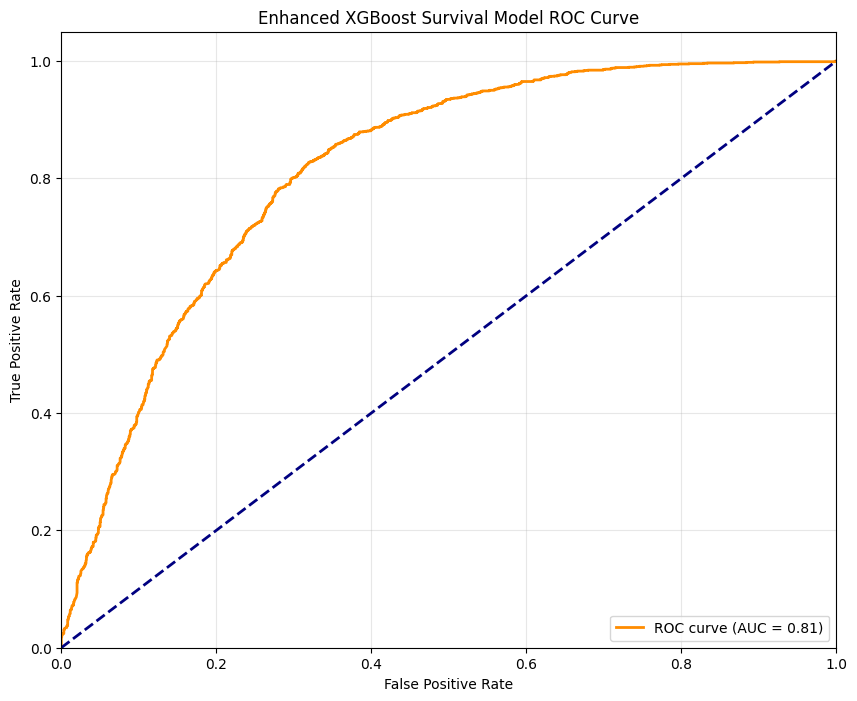


Model Performance Metrics:
Concordance Index: 0.7044
ROC AUC: 0.8149

Top 10 Important Features (with relative importance):
                                   Feature  Relative_Importance
0                       ApprovalFiscalYear             1.000000
1                         UnemploymentRate             0.101497
2                              SP500Return             0.060924
3                            GDPGrowthRate             0.044858
4                      SP500Return_squared             0.042061
5                 UnemploymentRate_squared             0.032323
6                    GDPGrowthRate_squared             0.025811
7                            JobsSupported             0.025191
8  GrossApproval_JobsSupported_interaction             0.020452
9                            GrossApproval             0.019215


In [162]:
c_index = concordance_index(y_test['SurvivalDays'], -predicted_default_prob,
                          y_test['Default'])

# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test['Default'], predicted_default_prob)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2,
        label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Enhanced XGBoost Survival Model ROC Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# Print feature importance
importance_df = pd.DataFrame(
    sorted(feature_importances_.items(), key=lambda x: x[1],
          reverse=True),
    columns=['Feature', 'Importance']
)
importance_df['Relative_Importance'] = (
    importance_df['Importance'] / importance_df['Importance'].max()
)

print("\nModel Performance Metrics:")
print(f"Concordance Index: {c_index:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("\nTop 10 Important Features (with relative importance):")
print(importance_df.head(10)[['Feature', 'Relative_Importance']])
